In [1]:
import torch
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
import supervised_dataset
import importlib
importlib.reload(supervised_dataset)

<module 'supervised_dataset' from '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Supervised/supervised_dataset.py'>

In [3]:
import sys
sys.path.insert(0, '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/geography-aware-ssl/moco_fmow/moco')
from ms_nl_resnet import MS_NL_ResNet18


/cephyr/users/benvin/Alvis/.local/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /cephyr/users/benvin/Alvis/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


In [4]:
fold = 'C'
gpu = 1

losses = pd.read_csv('moco_pretrained/fold_{}/losses_fold_{}_epoch_0020_.txt'.format(fold, fold), sep=",", header=None)
best_epoch = losses[1].argmin()
print("Best epoch: ", best_epoch)
print("Best epoch val_loss: ", losses[1].iloc[best_epoch])

model = MS_NL_ResNet18(num_classes=1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

## Supervised
checkpoint_path = 'moco_pretrained/fold_{}/checkpoint_fold_{}_{:04d}.pth.tar'.format(fold, fold, best_epoch)
print("Model loaded: ", checkpoint_path)
checkpoint = torch.load(checkpoint_path, map_location='cpu')

checkpoint_dict = dict()
for key in checkpoint['state_dict'].keys():
    resnet_key=key.replace("module.", "")
    checkpoint_dict[resnet_key]=checkpoint['state_dict'][key]

model.load_state_dict(checkpoint_dict)

loc = 'cuda:{}'.format(gpu)
checkpoint = torch.load('moco_pretrained/fold_{}/checkpoint_fold_{}_{:04d}.pth.tar'.format(fold, fold, best_epoch), map_location=loc)



#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Best epoch:  12
Best epoch val_loss:  203.81782080910423
Model loaded:  moco_pretrained/fold_C/checkpoint_fold_C_0012.pth.tar


In [5]:
torch.cuda.set_device(gpu)
model.cuda(gpu)
print()

criterion = torch.nn.MSELoss().cuda(gpu)

In [6]:
csv = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Supervised/dhs_clusters_paths.csv"
folds_path = '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/CreateFolds/new_dhs_incountry_folds.pkl'


with open(folds_path, 'rb') as handle:
        folds = pkl.load(handle)
        
test_dataset = supervised_dataset.SupervisedDataset(csv, csv_indices=folds[fold]['test'])

batch_size = 64
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)



In [7]:
# TEST MODEL
iwi_pred = []
iwi_true = []

model.eval()
for i, (images, labels) in enumerate(test_loader):
    #print(images.size())
    images = images.cuda(gpu)
    labels = labels.cuda(gpu)
    
    preds = model(images)
    preds = torch.squeeze(preds)
    #print(preds.size())
    
    loss = criterion(preds, labels)
    print(loss)
    
    for pred in preds:
        iwi_pred.append(pred.item())
    
    for label in labels:
        iwi_true.append(label.item())
    
    
    #iwi_preds.extend(preds.numpy())
    
    #print("batch: ", i)
    print(i, "/", len(test_loader))
    print()

tensor(386.0034, device='cuda:1', grad_fn=<MseLossBackward>)
0 / 178

tensor(247.2871, device='cuda:1', grad_fn=<MseLossBackward>)
1 / 178

tensor(776.9587, device='cuda:1', grad_fn=<MseLossBackward>)
2 / 178

tensor(80.7117, device='cuda:1', grad_fn=<MseLossBackward>)
3 / 178

tensor(166.2364, device='cuda:1', grad_fn=<MseLossBackward>)
4 / 178

tensor(189.9801, device='cuda:1', grad_fn=<MseLossBackward>)
5 / 178

tensor(225.3840, device='cuda:1', grad_fn=<MseLossBackward>)
6 / 178

tensor(142.8437, device='cuda:1', grad_fn=<MseLossBackward>)
7 / 178

tensor(863.4534, device='cuda:1', grad_fn=<MseLossBackward>)
8 / 178

tensor(59.6085, device='cuda:1', grad_fn=<MseLossBackward>)
9 / 178

tensor(140.5917, device='cuda:1', grad_fn=<MseLossBackward>)
10 / 178

tensor(167.4693, device='cuda:1', grad_fn=<MseLossBackward>)
11 / 178

tensor(154.1980, device='cuda:1', grad_fn=<MseLossBackward>)
12 / 178

tensor(122.5960, device='cuda:1', grad_fn=<MseLossBackward>)
13 / 178

tensor(162.7491, d

r2:  0.25103894226370316
slope:  0.5174771338979582 intercept:  22.896068353997727


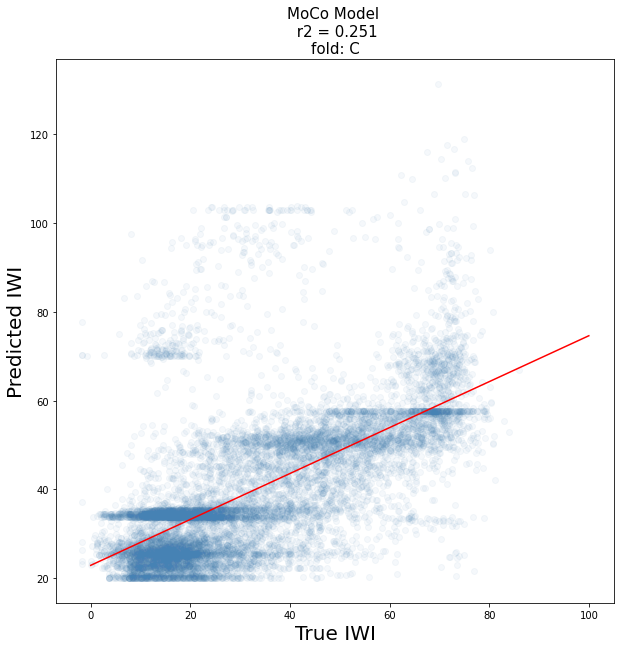

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline



r2 = r2_score(iwi_true, iwi_pred)
print("r2: ", r2)

plt.figure(figsize=(10,10))
plt.scatter(iwi_true, iwi_pred, alpha=0.05, c='steelblue')
m, b = np.polyfit(iwi_true, iwi_pred, 1)

x = [i for i in range(101)]
y = [i*m + b for i in x]

print("slope: ", m, "intercept: ", b)

plt.title('MoCo Model \n ' + 'r2 = ' + str(round(r2, 4)) + '\n' + 'fold: ' + str(fold), fontsize=15)
plt.xlabel('True IWI', fontsize=20)
plt.ylabel('Predicted IWI', fontsize=20)
plt.plot(x, y, c='red')



In [13]:
lossf = criterion(torch.Tensor(iwi_pred), torch.Tensor(iwi_true))
lossf

tensor(132.4766)

In [9]:
with open('moco_pretrained/preds_{}.pkl'.format(fold), 'wb') as f:
    pkl.dump(iwi_pred, f)

r2:  0.2588601240415669
slope:  0.5174771338979582 intercept:  22.896068353997727


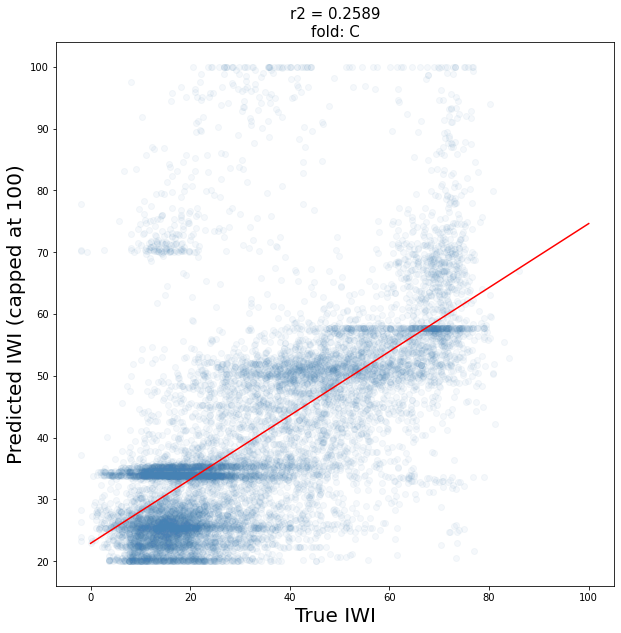

In [10]:
iwi_pred_capped = []
for iwi in iwi_pred:
    if iwi < 100:
        iwi_pred_capped.append(iwi)
    else:
        iwi_pred_capped.append(100)
        
r2 = r2_score(iwi_true, iwi_pred_capped)
print("r2: ", r2)

plt.figure(figsize=(10,10))
plt.scatter(iwi_true, iwi_pred_capped, alpha=0.05, c='steelblue')
m, b = np.polyfit(iwi_true, iwi_pred, 1)

x = [i for i in range(101)]
y = [i*m + b for i in x]

print("slope: ", m, "intercept: ", b)

plt.title('r2 = ' + str(round(r2, 4)) + '\n' + 'fold: ' + str(fold), fontsize=15)
plt.xlabel('True IWI', fontsize=20)
plt.ylabel('Predicted IWI (capped at 100)', fontsize=20)
plt.plot(x, y, c='red')